<div class="alert alert-success">
    <h1 align="center">Lesson 3: Object Classification with Localization</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

## Introduction

<img src='imgs/fish-competition-bb.png' width='90%'/>

<h6 align='center'>[Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring)</h6>

<h6>Goal:</h6>
- Detecting the species of the fish in a fishing boat, based on images captured from various angles.
- Classes: `ALB`, `BET`, `DOL`, `LAG`, `SHARK`, `YFT`, `OTHER`, `NoF` (no fish).

<img src='imgs/kaggle-fish-types.png' width='80%'/>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

Helper functions

In [2]:
def get_model(model_name, num_classes, pretrained=True):
    return models.__dict__[model_name](pretrained)


def read_annotations(path):
    """ Read Bounding Boxes from a json file.
    """
    anno_classes = [f.split('_')[0] for f in os.listdir(path)]
    bb_json = {}
    
    for c in anno_classes:
        j = json.load(open(f'{path}/{c}_labels.json', 'r'))
        for l in j:
            if 'annotations' in l and len(l['annotations']) > 0:
                fname = l['filename'].split('/')[-1]
                bb_json[fname] = sorted(
                    l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
    return bb_json


def bbox_to_r1c1r2c2(bbox):
    """ Convert BB from [h, w, x, y] to [r1, c1, r2, c2] format.
    """
    
    # extract h, w, x, y and convert to list
    bb = []
    bb.append(bbox['height'])
    bb.append(bbox['width'])
    bb.append(max(bbox['x'], 0))
    bb.append(max(bbox['y'], 0))
    
    # convert to float
    bb = [float(x) for x in bb]
    
    # convert to [r1, c1, r2, c2] format
    r1 = bb[3]
    c1 = bb[2]
    r2 = r1 + bb[0]
    c2 = c1 + bb[1]
    
    return [r1, c1, r2, c2]


def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor. 
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)
    
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws
    
    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]
    
    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale
    
    # scale image
    img = cv2.resize(img, (w, h))
    
    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)
    
    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Data

In [3]:
DATA_DIR = "/media/razavi/DATA//datasets/kaggle/fish"

train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/valid'
anno_dir = f'{DATA_DIR}/annotations'

sz = 299  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8

### Read annotations (bounding boxes)

In [4]:
bb_json = read_annotations(anno_dir)

In [5]:
print(list(bb_json.keys())[:5])

['img_07917.jpg', 'img_07915.jpg', 'img_07914.jpg', 'img_07912.jpg', 'img_07904.jpg']


In [6]:
print(bb_json['img_07917.jpg'])

{'class': 'rect', 'height': 151.06975503141317, 'width': 383.68430384213445, 'x': 547.1578480789353, 'y': 193.3597426816281}


### Files structure

In [7]:
print(os.listdir(DATA_DIR))

['annotations', 'sample', 'test', 'train', 'valid']


In [8]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [9]:
files = glob(f'{DATA_DIR}/train/ALB/*.*')
files[:5]

['/media/razavi/DATA//datasets/kaggle/fish/train/ALB/img_00029.jpg',
 '/media/razavi/DATA//datasets/kaggle/fish/train/ALB/img_00032.jpg',
 '/media/razavi/DATA//datasets/kaggle/fish/train/ALB/img_00038.jpg',
 '/media/razavi/DATA//datasets/kaggle/fish/train/ALB/img_00039.jpg',
 '/media/razavi/DATA//datasets/kaggle/fish/train/ALB/img_00041.jpg']

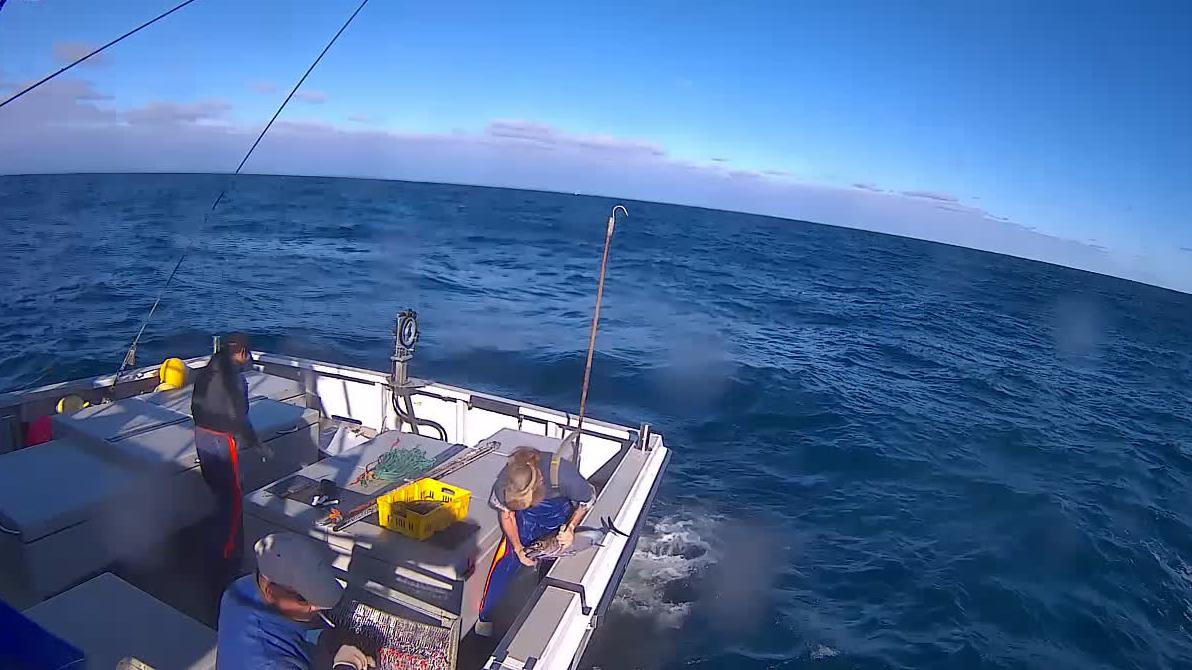

In [10]:
Image.open(files[1])

### Annotations

In [11]:
anno_files = os.listdir(anno_dir)
anno_files

['alb_labels.json',
 'bet_labels.json',
 'dol_labels.json',
 'lag_labels.json',
 'other_labels.json',
 'shark_labels.json',
 'yft_labels.json']

In [12]:
filename = f'{anno_dir}/{anno_files[0]}'
print(open(filename, 'r').read())

[
    {
        "annotations": [
            {
                "class": "rect",
                "height": 151.06975503141317,
                "width": 383.68430384213445,
                "x": 547.1578480789353,
                "y": 193.3597426816281
            }
        ],
        "class": "image",
        "filename": "img_07917.jpg"
    },
    {
        "annotations": [
            {
                "class": "rect",
                "height": 65.00000000000023,
                "width": 166.00000000000063,
                "x": 469.00000000000165,
                "y": 448.0000000000016
            },
            {
                "class": "rect",
                "height": 143.0000000000005,
                "width": 98.00000000000036,
                "x": 92.00000000000033,
                "y": 495.00000000000176
            }
        ],
        "class": "image",
        "filename": "img_07915.jpg"
    },
    {
        "annotations": [
            {
                "class": "rect",
     

### Create validation data

In [13]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

### Fish Dataset

In [14]:
class FishDataset(Dataset):
    def __init__(self, ds, bboxes, sz=299):
        """ Prepare fish dataset
        
        Inputs:
            root: the directory which contains all required data such as images, labels, etc.
            ds: torchvision ImageFolder dataset.
            bboxes: a dictionary containing the coordinates of the bounding box in each images
            transforms: required transformations on each image
        """
        self.imgs = ds.imgs
        self.classes = ds.classes
        self.bboxes = bboxes
        self.sz = sz
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, index):
        img, lbl = self.imgs[index]
        
        # get bounding box
        img_name = os.path.basename(img)
        if img_name in self.bboxes.keys():
            bbox = self.bboxes[img_name]
        else:
            bbox = {'class': 'rect', 'height': 0., 'width': 0., 'x': 0., 'y': 0.}
            
        # convert [h, w, x, y] to [r1, c1, r2, c2] format        
        bbox = bbox_to_r1c1r2c2(bbox)
        
        # read image and perform transformations
        image = Image.open(img).convert('RGB')
        w, h = image.size
        
        w_scale = sz / w
        h_scale = sz / h
        
        # transformations
        image = self.tfms(image)
        
        # normalize and scale bounding box
        bbox[0] = (bbox[0] / h) * h_scale
        bbox[1] = (bbox[1] / w) * w_scale
        bbox[2] = (bbox[2] / h) * h_scale
        bbox[3] = (bbox[3] / w) * w_scale
        
        # return image tensor, label tensor and bounding box tensor
        return image, lbl, torch.Tensor(bbox), (w, h)
    
    def __len__(self):
        return len(self.imgs)

### Training and Validation dataset

In [15]:
# training data
train_data = datasets.ImageFolder(train_dir)
train_ds = FishDataset(train_data, bb_json, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# validation data
valid_data = datasets.ImageFolder(valid_dir)
valid_ds = FishDataset(valid_data, bb_json, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

### Visulaize data

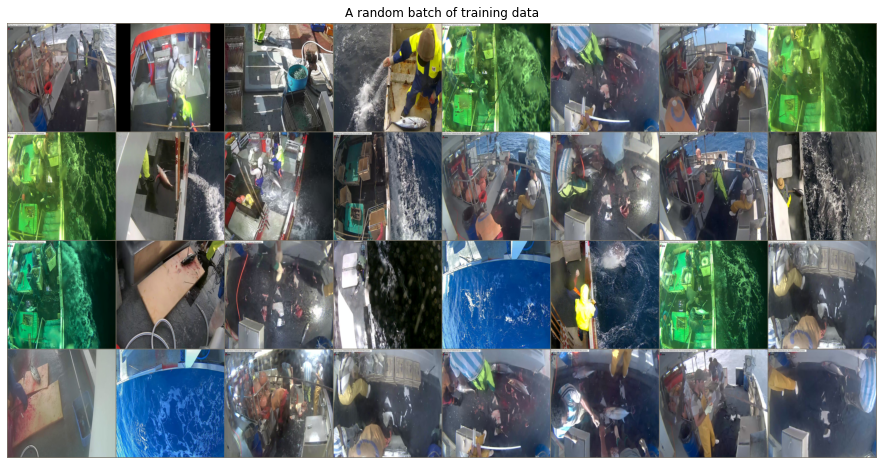

In [16]:
dataiter = iter(train_dl)
imgs, lbls, bbs, sizes = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

torch.Size([3, 299, 299])
0 : ALB
[0.22120462 0.10035407 0.30090335 0.11167606]


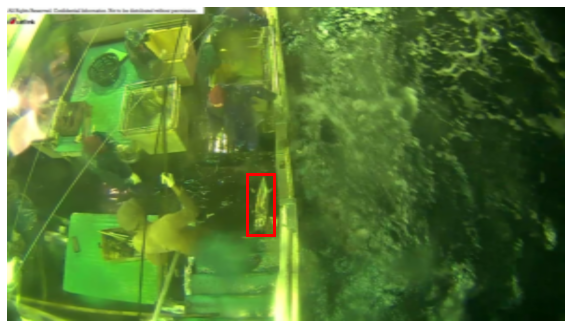

In [17]:
# get one specific data from training data
img, lbl, bb, (w, h) = train_ds[10]

# print size, label, and bounding box
print(img.size())
print(lbl, ':', train_ds.classes[lbl])
print(bb.numpy())

# plot image and bounding box
plot_bbox(img, bb, w, h)

## Classification with Localization

<img src='imgs/localization.png' width='90%'/>

### Model

In [18]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes
        
        # create cnn model
        model = get_model(model_name, num_classes)
        
        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model
    
    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, torch.sigmoid(coords)     # sigmoid output is in [0, 1]

### Loss Function

Loss function has two parts:
- Cross Entropy Loss (for classification)
- Sum of Squared Errors (for regression)

In [19]:
class LocalizationLoss(nn.Module):
    def __init__(self, num_classes=8):
        super(LocalizationLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
        self.mse_loss = nn.MSELoss(reduction='sum')
        
    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)
        
        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0
        
        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ClassifierLocalizer(model_name)
model = model.to(device)
    
criterion = LocalizationLoss()
criterion = criterion.to(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [21]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=3)

Epoch 1/3
----------


/home/razavi/Documents/mygithub/DeepLearning/Deep_Learning_in_Python_2018/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  train Loss: 34.05300 (21.55690 + 1.24961), Acc: 0.79418
  valid Loss: 7.42997 (6.20697 + 0.12230), Acc: 0.94967

Epoch 2/3
----------
  train Loss: 3.62773 (2.52090 + 0.11068), Acc: 0.98445
  valid Loss: 5.16499 (4.20819 + 0.09568), Acc: 0.96954

Epoch 3/3
----------
  train Loss: 1.60140 (0.79708 + 0.08043), Acc: 0.99570
  valid Loss: 3.96232 (3.27223 + 0.06901), Acc: 0.97616

Training complete in 6m 9s
Best val Acc: 0.9762


### Predicting bounding boxes

In [ ]:
# load weights
# model.load_state_dict(torch.load('models/resnet34-299-loc-epoch-9-acc-0.97483.pth'))

5 : OTHER


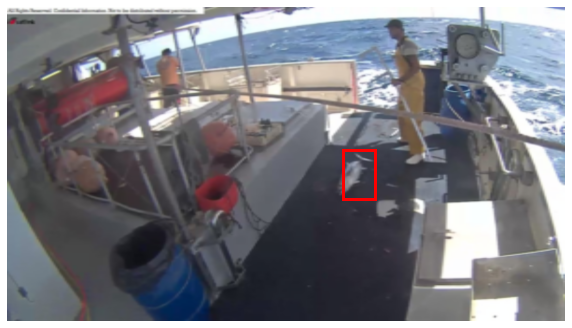

In [30]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(imgs.to(device))

scores = scores.detach().cpu().numpy()
locs = locs.detach().cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy()[0], sizes[1].numpy()[0]

plot_bbox(imgs[0], pred_bb, w, h)

## Other applications

### Key point detection

<img src='imgs/key_points.png' width='80%'/>

### Pose estimation

<img src='imgs/pose.png' width='80%'/>